# Dropped Features 

- avg_energy_kWh
Ye ek derived aur inconsistent feature hai, jo hourly charging demand ko properly explain nahi karta.

- energy_consumption_kWh
Energy consumption charging sessions ke baad pata chalta hai, isliye ye target leakage cause karta hai.

- peak_power_kW
Peak power charging ke baad record hota hai aur energy ke saath highly correlated hota hai, isliye demand predict karne ke liye suitable nahi hai.

- idle_duration_minutes
Idle duration directly batata hai ki us hour me charging hui ya nahi, isliye model ko future ka answer pehle hi mil jata hai (data leakage).

- active_duration_minutes
Active duration bhi charging hone ke baad milta hai aur prediction time pe available nahi hota.

### 
humne post-event aur leakage-causing features ko hata diya taaki demand forecasting model honest aur realistic rahe

# Goal 
- Primary Goal (num_sessions) : num_sessions actual charging demand dikhata hai, aur backend load planning, demand heatmap aur system utilization sab isi par depend karta hai.

- Secondary Goal (Pricing) : Price ko directly predict nahi karte, balki forecasted demand ke basis par future price ko adjust ya suggest karte hain.

In [1]:
import pandas as pd
import numpy as np
DATA_PATH = r"F:\task\ev_charging_forecast\data\raw\karocharge_delhi_30day_realistic_synthetic_mixed_idle.csv"
df = pd.read_csv(DATA_PATH)

In [2]:
data = df.copy()

data.drop(
    columns=[
        "avg_energy_kWh",
        "energy_consumption_kWh",
        "peak_power_kW",
        "idle_duration_minutes",
        "active_duration_minutes",
        "station_id",
        "is_idle_time",
        "price_inr"
    ],
    inplace=True
)
data.head()

,timestamp,num_sessions,is_holiday,weather_temp,weather_condition
0,09/11/2025 01:00,1,1,10.970434,Haze
1,09/11/2025 02:00,1,1,13.846141,Clear
2,09/11/2025 03:00,0,1,10.982564,Haze
3,09/11/2025 04:00,3,1,12.506471,Partly Cloudy
4,09/11/2025 05:00,0,1,12.345760,Clear


In [3]:
# make sure timestamp is datetime
data["timestamp"] = pd.to_datetime(
    data["timestamp"], format="%d/%m/%Y %H:%M"
)

# set timestamp as index
data.set_index("timestamp", inplace=True)

# now create time features
data["hour"] = data.index.hour
data["day_of_week"] = data.index.dayofweek
data["is_weekend"] = data["day_of_week"].isin([5, 6]).astype(int)

data.head()


,num_sessions,is_holiday,weather_temp,weather_condition,hour,day_of_week,is_weekend
timestamp,,,,,,,
2025-11-09 01:00:00,1,1,10.970434,Haze,1,6,1
2025-11-09 02:00:00,1,1,13.846141,Clear,2,6,1
2025-11-09 03:00:00,0,1,10.982564,Haze,3,6,1
2025-11-09 04:00:00,3,1,12.506471,Partly Cloudy,4,6,1
2025-11-09 05:00:00,0,1,12.345760,Clear,5,6,1


feature that will be helpful
- lagged demand (short lags)

In [4]:
# STEP 5.2: Short lag features

data["lag_1h"] = data["num_sessions"].shift(1)
data["lag_3h"] = data["num_sessions"].shift(3)
data["lag_5h"] = data["num_sessions"].shift(5)
data["lag_7h"] = data["num_sessions"].shift(7)

data.head(10)


,num_sessions,is_holiday,weather_temp,weather_condition,hour,day_of_week,is_weekend,lag_1h,lag_3h,lag_5h,lag_7h
timestamp,,,,,,,,,,,
2025-11-09 01:00:00,1,1,10.970434,Haze,1,6,1,NaN,NaN,NaN,NaN
2025-11-09 02:00:00,1,1,13.846141,Clear,2,6,1,1.0,NaN,NaN,NaN
2025-11-09 03:00:00,0,1,10.982564,Haze,3,6,1,1.0,NaN,NaN,NaN
2025-11-09 04:00:00,3,1,12.506471,Partly Cloudy,4,6,1,0.0,1.0,NaN,NaN
2025-11-09 05:00:00,0,1,12.345760,Clear,5,6,1,3.0,1.0,NaN,NaN
2025-11-09 06:00:00,0,1,12.710807,Clear,6,6,1,0.0,0.0,1.0,NaN
2025-11-09 07:00:00,0,1,17.315234,Haze,7,6,1,0.0,3.0,1.0,NaN
2025-11-09 08:00:00,1,1,18.837910,Haze,8,6,1,0.0,0.0,0.0,1.0
2025-11-09 09:00:00,0,1,21.603835,Clear,9,6,1,1.0,0.0,3.0,1.0


In [5]:
data["lag_1h"] = data["lag_1h"].fillna(0)
data["lag_3h"] = data["lag_3h"].fillna(0)
data["lag_5h"] = data["lag_5h"].fillna(0)
data["lag_7h"] = data["lag_7h"].fillna(0)

In [6]:
data

,num_sessions,is_holiday,weather_temp,weather_condition,hour,day_of_week,is_weekend,lag_1h,lag_3h,lag_5h,lag_7h
timestamp,,,,,,,,,,,
2025-11-09 01:00:00,1,1,10.970434,Haze,1,6,1,0.0,0.0,0.0,0.0
2025-11-09 02:00:00,1,1,13.846141,Clear,2,6,1,1.0,0.0,0.0,0.0
2025-11-09 03:00:00,0,1,10.982564,Haze,3,6,1,1.0,0.0,0.0,0.0
2025-11-09 04:00:00,3,1,12.506471,Partly Cloudy,4,6,1,0.0,1.0,0.0,0.0
2025-11-09 05:00:00,0,1,12.345760,Clear,5,6,1,3.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-12-08 21:00:00,2,0,14.929285,Partly Cloudy,21,0,0,2.0,1.0,2.0,0.0
2025-12-08 22:00:00,1,0,12.400268,Haze,22,0,0,2.0,0.0,1.0,0.0
2025-12-08 23:00:00,1,0,13.617752,Clear,23,0,0,1.0,2.0,1.0,2.0


In [7]:
# CELL 1: Check current data structure
print("=== DATA STRUCTURE CHECK ===")
print(f"Data type: {type(data)}")
print(f"Data shape: {data.shape}")
print(f"\nColumns present: {data.columns.tolist()}")
print(f"\nIndex type: {type(data.index)}")
print(f"Index name: {data.index.name}")
print(f"\nFirst 5 rows:")
print(data.head())
print(f"\nMissing values in each column:")
print(data.isnull().sum())

=== DATA STRUCTURE CHECK ===
Data type: <class 'pandas.DataFrame'>
Data shape: (721, 11)

Columns present: ['num_sessions', 'is_holiday', 'weather_temp', 'weather_condition', 'hour', 'day_of_week', 'is_weekend', 'lag_1h', 'lag_3h', 'lag_5h', 'lag_7h']

Index type: <class 'pandas.DatetimeIndex'>
Index name: timestamp

First 5 rows:
                     num_sessions  is_holiday  weather_temp weather_condition  \
timestamp                                                                       
2025-11-09 01:00:00             1           1     10.970434              Haze   
2025-11-09 02:00:00             1           1     13.846141             Clear   
2025-11-09 03:00:00             0           1     10.982564              Haze   
2025-11-09 04:00:00             3           1     12.506471     Partly Cloudy   
2025-11-09 05:00:00             0           1     12.345760             Clear   

                     hour  day_of_week  is_weekend  lag_1h  lag_3h  lag_5h  \
timestamp            

In [8]:
# CELL 2: Add cyclical features
print("=== ADDING CYCLICAL FEATURES ===")

import numpy as np

# Add cyclical time features
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

# Add time of day categories
data['is_night'] = (data['hour'].between(0, 5)).astype(int)
data['is_morning'] = (data['hour'].between(6, 11)).astype(int)
data['is_afternoon'] = (data['hour'].between(12, 16)).astype(int)
data['is_evening'] = (data['hour'].between(17, 23)).astype(int)

print(f"✅ Added 8 new features")
print(f"Total columns now: {len(data.columns)}")
print(f"\nNew columns: {[col for col in data.columns if col not in ['num_sessions', 'is_holiday', 'weather_temp', 'weather_condition', 'hour', 'day_of_week', 'is_weekend', 'lag_1h', 'lag_3h', 'lag_5h', 'lag_7h']]}")
print(f"\nSample of new features:")
print(data[['hour', 'hour_sin', 'hour_cos', 'is_night', 'is_morning']].head())

=== ADDING CYCLICAL FEATURES ===
✅ Added 8 new features
Total columns now: 19

New columns: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'is_night', 'is_morning', 'is_afternoon', 'is_evening']

Sample of new features:
                     hour  hour_sin  hour_cos  is_night  is_morning
timestamp                                                          
2025-11-09 01:00:00     1  0.258819  0.965926         1           0
2025-11-09 02:00:00     2  0.500000  0.866025         1           0
2025-11-09 03:00:00     3  0.707107  0.707107         1           0
2025-11-09 04:00:00     4  0.866025  0.500000         1           0
2025-11-09 05:00:00     5  0.965926  0.258819         1           0


In [9]:
# CELL 3: Add rolling statistics
print("=== ADDING ROLLING STATISTICS ===")

# Add rolling features
# data['rolling_mean_3h'] = data['num_sessions'].rolling(window=3, min_periods=1).mean()
data['rolling_mean_6h'] = data['num_sessions'].rolling(window=6, min_periods=1).mean()
data['rolling_mean_12h'] = data['num_sessions'].rolling(window=12, min_periods=1).mean()
data['rolling_mean_24h'] = data['num_sessions'].rolling(window=24, min_periods=1).mean()

# Fill NaN values
rolling_cols = ['rolling_mean_6h', 'rolling_mean_12h', 'rolling_mean_24h']
for col in rolling_cols:
    data[col] = data[col].fillna(0)

print(f"✅ Added 4 rolling features")
print(f"Total columns now: {len(data.columns)}")
print(f"\nRolling features stats:")
print(data[rolling_cols].describe())
print(f"\nSample rolling values:")
print(data[['num_sessions', 'rolling_mean_6h']].head(10))

=== ADDING ROLLING STATISTICS ===
✅ Added 4 rolling features
Total columns now: 22

Rolling features stats:
       rolling_mean_6h  rolling_mean_12h  rolling_mean_24h
count       721.000000        721.000000        721.000000
mean          0.847781          0.846727          0.846415
std           0.385943          0.254451          0.159513
min           0.000000          0.166667          0.375000
25%           0.500000          0.666667          0.708333
50%           0.833333          0.833333          0.875000
75%           1.000000          1.000000          0.958333
max           2.000000          1.666667          1.333333

Sample rolling values:
                     num_sessions  rolling_mean_6h
timestamp                                         
2025-11-09 01:00:00             1         1.000000
2025-11-09 02:00:00             1         1.000000
2025-11-09 03:00:00             0         0.666667
2025-11-09 04:00:00             3         1.250000
2025-11-09 05:00:00            

In [10]:
# ============================
# EV CHARGING DATA ANALYSIS - NO PLOTS
# ============================
df=data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ===== 1. LOAD DATA =====
print("📂 LOADING DATA...")
# Try different possible file names or provide your file path

print(f"✅ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# ===== 2. SHOW COLUMNS =====
print("\n" + "="*60)
print("📋 COLUMNS IN DATASET:")
print("="*60)
print("Index:", df.columns.tolist())

# ===== 3. BASIC DATASET INFO =====
print("\n" + "="*60)
print("📊 DATASET INFORMATION:")
print("="*60)
print(f"Total rows: {df.shape[0]:,}")
print(f"Total columns: {df.shape[1]}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

# ===== 4. DATA TYPES =====
print("\n" + "="*60)
print("🔧 DATA TYPES:")
print("="*60)
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"{dtype}: {count} columns")

# ===== 5. MISSING VALUES =====
print("\n" + "="*60)
print("❓ MISSING VALUES ANALYSIS:")
print("="*60)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percent': missing_percent.values
})

# Filter only columns with missing values
missing_df = missing_df[missing_df['Missing_Count'] > 0]

if len(missing_df) > 0:
    print(missing_df.sort_values('Missing_Percent', ascending=False).to_string(index=False))
else:
    print("✅ No missing values found!")

# ===== 6. BASIC STATISTICS =====
print("\n" + "="*60)
print("📈 NUMERICAL COLUMNS STATISTICS:")
print("="*60)

# Identify numerical columns (excluding binary/categorical)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove binary columns (0/1) from numerical stats
binary_cols = [col for col in numerical_cols if df[col].nunique() == 2]
real_numerical = [col for col in numerical_cols if col not in binary_cols]

if real_numerical:
    print(df[real_numerical].describe().round(2))
else:
    print("No continuous numerical columns found")

# ===== 7. CATEGORICAL/BINARY COLUMNS =====
print("\n" + "="*60)
print("📊 CATEGORICAL & BINARY COLUMNS:")
print("="*60)

# Binary columns (0/1)
binary_info = []
for col in binary_cols:
    if col in df.columns:
        value_counts = df[col].value_counts()
        binary_info.append({
            'Column': col,
            '0_Count': value_counts.get(0, 0),
            '1_Count': value_counts.get(1, 0),
            '1_Percent': (value_counts.get(1, 0) / len(df)) * 100
        })

if binary_info:
    binary_df = pd.DataFrame(binary_info)
    print("Binary Columns (0/1):")
    print(binary_df.to_string(index=False))
else:
    print("No binary columns found")

# ===== 8. KEY COLUMN ANALYSIS =====
print("\n" + "="*60)
print("🔑 KEY COLUMN - num_sessions ANALYSIS:")
print("="*60)

if 'num_sessions' in df.columns:
    sessions_stats = {
        'Total Sessions': f"{df['num_sessions'].sum():,.0f}",
        'Mean Sessions/Hour': f"{df['num_sessions'].mean():.2f}",
        'Median Sessions/Hour': f"{df['num_sessions'].median():.2f}",
        'Std Dev': f"{df['num_sessions'].std():.2f}",
        'Min Sessions': f"{df['num_sessions'].min():.0f}",
        'Max Sessions': f"{df['num_sessions'].max():.0f}",
        'Hours with 0 sessions': f"{(df['num_sessions'] == 0).sum():,}",
        'Percent 0 sessions': f"{(df['num_sessions'] == 0).sum() / len(df) * 100:.2f}%"
    }
    
    for key, value in sessions_stats.items():
        print(f"{key}: {value}")
else:
    print("⚠️ 'num_sessions' column not found in dataset")

# ===== 9. TIME-RELATED COLUMNS =====
print("\n" + "="*60)
print("⏰ TIME-RELATED FEATURES DISTRIBUTION:")
print("="*60)

time_cols = ['hour', 'day_of_week', 'is_weekend', 'is_night', 'is_morning', 
             'is_afternoon', 'is_evening']

for col in time_cols:
    if col in df.columns:
        print(f"\n{col}:")
        value_counts = df[col].value_counts().sort_index()
        for val, count in value_counts.items():
            percent = (count / len(df)) * 100
            print(f"  {val}: {count:,} ({percent:.1f}%)")

# ===== 10. LAG FEATURES ANALYSIS =====
print("\n" + "="*60)
print("🔄 LAG FEATURES CORRELATION WITH num_sessions:")
print("="*60)

lag_cols = ['lag_1h', 'lag_3h', 'lag_5h', 'lag_7h']
existing_lag_cols = [col for col in lag_cols if col in df.columns]

if existing_lag_cols and 'num_sessions' in df.columns:
    for lag_col in existing_lag_cols:
        corr = df['num_sessions'].corr(df[lag_col])
        print(f"{lag_col}: Correlation = {corr:.4f}")

# ===== 11. WEATHER FEATURES =====
print("\n" + "="*60)
print("🌤️ WEATHER-RELATED FEATURES:")
print("="*60)

# Temperature
if 'weather_temp' in df.columns:
    print("\nTemperature Statistics:")
    print(f"  Mean: {df['weather_temp'].mean():.1f}°C")
    print(f"  Min: {df['weather_temp'].min():.1f}°C")
    print(f"  Max: {df['weather_temp'].max():.1f}°C")
    print(f"  Std: {df['weather_temp'].std():.1f}°C")

# Weather conditions
weather_cols = [col for col in df.columns if 'weather_' in col and col != 'weather_temp']
if weather_cols:
    print("\nWeather Condition Distribution:")
    for col in weather_cols:
        if df[col].sum() > 0:  # Only show if condition occurred
            count = df[col].sum()
            percent = (count / len(df)) * 100
            condition = col.replace('weather_', '')
            print(f"  {condition}: {count:,} hours ({percent:.1f}%)")

# ===== 12. ROLLING MEANS =====
print("\n" + "="*60)
print("📊 ROLLING MEANS STATISTICS:")
print("="*60)

rolling_cols = [ 'rolling_mean_6h', 'rolling_mean_12h', 'rolling_mean_24h']
existing_rolling = [col for col in rolling_cols if col in df.columns]

for col in existing_rolling:
    print(f"\n{col}:")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Std: {df[col].std():.2f}")
    print(f"  Min: {df[col].min():.2f}")
    print(f"  Max: {df[col].max():.2f}")

# ===== 13. DATA QUALITY SUMMARY =====
print("\n" + "="*60)
print("✅ DATA QUALITY SUMMARY:")
print("="*60)

print(f"1. Total Records: {df.shape[0]:,}")
print(f"2. Complete Cases: {df.dropna().shape[0]:,} ({(df.dropna().shape[0] / df.shape[0]) * 100:.1f}%)")
print(f"3. Duplicate Rows: {df.duplicated().sum():,}")
print(f"4. Columns with Missing Data: {len(missing_df)}")
print(f"5. Zero Session Hours: {(df['num_sessions'] == 0).sum() if 'num_sessions' in df.columns else 'N/A'}")

print("\n" + "="*60)
print("🎯 RECOMMENDATION FOR FORECAST:")
print("="*60)
print("1. ✅ Features are ready (lags, time features, weather)")
print("2. 🔧 Check for missing values in lag features")
print("3. 📈 Use XGBoost/LGBM with these features")
print("4. ⚠️ If num_sessions has many zeros, consider Poisson regression")
print("5. 🎯 Use hour, day_of_week, lags as key predictors")

📂 LOADING DATA...
✅ Dataset loaded: 721 rows, 22 columns

📋 COLUMNS IN DATASET:
Index: ['num_sessions', 'is_holiday', 'weather_temp', 'weather_condition', 'hour', 'day_of_week', 'is_weekend', 'lag_1h', 'lag_3h', 'lag_5h', 'lag_7h', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'is_night', 'is_morning', 'is_afternoon', 'is_evening', 'rolling_mean_6h', 'rolling_mean_12h', 'rolling_mean_24h']

📊 DATASET INFORMATION:
Total rows: 721
Total columns: 22
Memory usage: 0.16 MB

🔧 DATA TYPES:
float64: 12 columns
int64: 7 columns
int32: 2 columns
str: 1 columns

❓ MISSING VALUES ANALYSIS:
✅ No missing values found!

📈 NUMERICAL COLUMNS STATISTICS:
       num_sessions  weather_temp    hour  day_of_week  lag_1h  lag_3h  \
count        721.00        721.00  721.00       721.00  721.00  721.00   
mean           0.85         17.63   11.49         2.99    0.85    0.84   
std            0.90          5.17    6.93         2.08    0.90    0.90   
min            0.00          9.05    0.00         0.00    0

TypeError: '>' not supported between instances of 'str' and 'int'

In [11]:
df.columns

Index(['num_sessions', 'is_holiday', 'weather_temp', 'weather_condition',
       'hour', 'day_of_week', 'is_weekend', 'lag_1h', 'lag_3h', 'lag_5h',
       'lag_7h', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'is_night',
       'is_morning', 'is_afternoon', 'is_evening', 'rolling_mean_6h',
       'rolling_mean_12h', 'rolling_mean_24h'],
      dtype='str')

In [12]:
OUTPUT_PATH = "../data/processed/ev_charging_analysis_ready.csv"

df.to_csv(OUTPUT_PATH, index=True)

print(f"✅ Data saved successfully at: {OUTPUT_PATH}")

✅ Data saved successfully at: ../data/processed/ev_charging_analysis_ready.csv


In [ ]:
# ============================
# EXISTING DATA SE FORECAST
# ============================

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta

# 1. Load existing data
print("📊 USING EXISTING DATA FOR FORECAST...")

# Agar timestamp column nahi hai toh assume last 30 days ka data
# Hum last 7 days ke pattern se next 7 days predict karenge

# 2. Prepare features from existing data
X = df.drop(columns=['num_sessions'])
y = df['num_sessions']

# 3. Train model on ALL existing data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# 4. Generate next 7 days features (existing pattern repeat)
last_hour = df['hour'].iloc[-1]
last_day_of_week = df['day_of_week'].iloc[-1]

future_features = []
for i in range(168):  # 7 days * 24 hours
    hour = (last_hour + i + 1) % 24
    day_of_week = (last_day_of_week + (i + 1) // 24) % 7
    
    # Same hour ke historical pattern use karo
    same_hour_data = df[df['hour'] == hour]
    
    if len(same_hour_data) > 0:
        # Historical average features
        feature_row = same_hour_data.mean().to_dict()
        feature_row['hour'] = hour
        feature_row['day_of_week'] = day_of_week
        feature_row['is_weekend'] = 1 if day_of_week in [5, 6] else 0
    else:
        # Default features
        feature_row = {
            'hour': hour,
            'day_of_week': day_of_week,
            'is_weekend': 1 if day_of_week in [5, 6] else 0,
            'weather_temp': df['weather_temp'].mean(),
            # 'rolling_mean_3h': df['num_sessions'].tail(3).mean(),
            'rolling_mean_24h': df['num_sessions'].tail(24).mean()
        }
    
    # Add all required columns
    for col in X.columns:
        if col not in feature_row:
            feature_row[col] = 0
    
    future_features.append(feature_row)

# 5. Create future dataframe
future_df = pd.DataFrame(future_features)
future_df = future_df[X.columns]  # Same order as training

# 6. Predict
future_predictions = model.predict(future_df)

# 7. Round to integers (0, 1, 2, 3)
future_predictions = np.round(future_predictions).clip(0, 3)

# 8. Create final forecast dataframe
last_timestamp = None  # Agar timestamp column ho toh use karo
start_date = datetime.now().replace(minute=0, second=0, microsecond=0)

forecast_dates = [start_date + timedelta(hours=i) for i in range(168)]

result_df = pd.DataFrame({
    'Date_Hour': forecast_dates,
    'Predicted_Sessions': future_predictions.astype(int),
    'Lower_Bound': (future_predictions - 0.5).clip(0),
    'Upper_Bound': (future_predictions + 0.5).clip(0, 3)
})

# 9. Save result
result_df.to_csv('7day_forecast_existing_data.csv', index=False)

# 10. Show summary
print(f"\n✅ FORECAST COMPLETE")
print(f"Total predicted sessions: {result_df['Predicted_Sessions'].sum()}")
print(f"Average per hour: {result_df['Predicted_Sessions'].mean():.2f}")
print(f"Zero hours: {(result_df['Predicted_Sessions'] == 0).sum()}")
print(f"File saved: '7day_forecast_existing_data.csv'")

# 11. Show first 24 hours
print("\n📅 FIRST 24 HOURS:")
for i in range(24):
    row = result_df.iloc[i]
    print(f"{row['Date_Hour'].strftime('%m-%d %H:%M')}: {row['Predicted_Sessions']} sessions")

📊 USING EXISTING DATA FOR FORECAST...


f:\task\ev_charging_forecast\venv\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
f:\task\ev_charging_forecast\venv\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
f:\task\ev_charging_forecast\venv\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
f:\task\ev_charging_forecast\venv\Lib\site-packages\sklearn\utils\paralle


✅ FORECAST COMPLETE
Total predicted sessions: 127
Average per hour: 0.76
Zero hours: 61
File saved: '7day_forecast_existing_data.csv'

📅 FIRST 24 HOURS:
01-29 13:00: 1 sessions
01-29 14:00: 0 sessions
01-29 15:00: 0 sessions
01-29 16:00: 1 sessions
01-29 17:00: 0 sessions
01-29 18:00: 0 sessions
01-29 19:00: 2 sessions
01-29 20:00: 2 sessions
01-29 21:00: 2 sessions
01-29 22:00: 1 sessions
01-29 23:00: 1 sessions
01-30 00:00: 0 sessions
01-30 01:00: 1 sessions
01-30 02:00: 0 sessions
01-30 03:00: 1 sessions
01-30 04:00: 1 sessions
01-30 05:00: 1 sessions
01-30 06:00: 1 sessions
01-30 07:00: 1 sessions
01-30 08:00: 1 sessions
01-30 09:00: 1 sessions
01-30 10:00: 0 sessions
01-30 11:00: 0 sessions
01-30 12:00: 0 sessions


f:\task\ev_charging_forecast\venv\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
f:\task\ev_charging_forecast\venv\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
f:\task\ev_charging_forecast\venv\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
f:\task\ev_charging_forecast\venv\Lib\site-packages\sklearn\utils\paralle

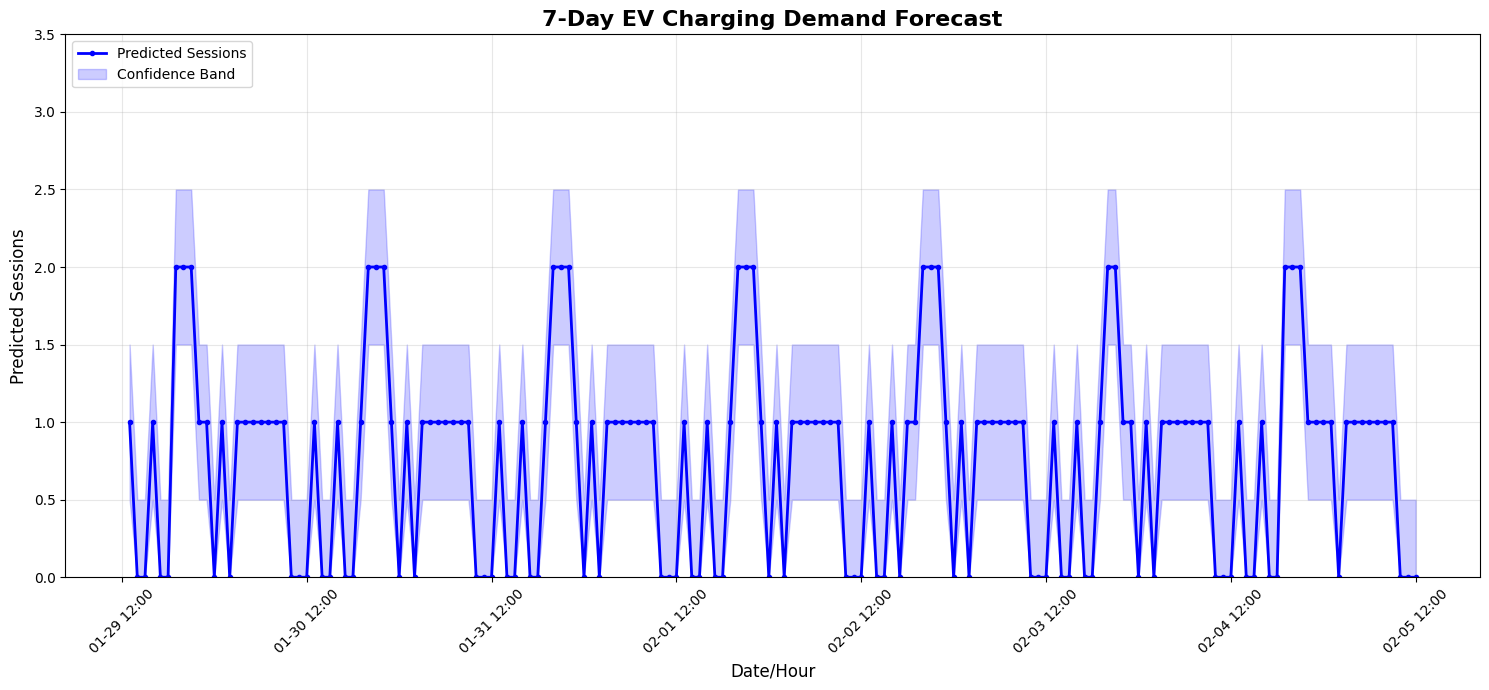

✅ Graph saved: '7day_ev_forecast_graph.png'
✅ CSV file: '7day_forecast_existing_data.csv'

🎯 MISSION COMPLETE!


In [ ]:
# ============================
# FINAL GRAPH GENERATION
# ============================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load forecast data
df_forecast = pd.read_csv('7day_forecast_existing_data.csv')
df_forecast['Date_Hour'] = pd.to_datetime(df_forecast['Date_Hour'])

# Create PDF-style graph
plt.figure(figsize=(15, 7))

# Plot predicted sessions (line)
plt.plot(df_forecast['Date_Hour'], df_forecast['Predicted_Sessions'], 
         color='blue', linewidth=2, label='Predicted Sessions', marker='o', markersize=3)

# Plot confidence band (shaded area)
plt.fill_between(df_forecast['Date_Hour'], 
                 df_forecast['Lower_Bound'], 
                 df_forecast['Upper_Bound'],
                 color='blue', alpha=0.2, label='Confidence Band')

# Formatting
plt.title('7-Day EV Charging Demand Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date/Hour', fontsize=12)
plt.ylabel('Predicted Sessions', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Format X-axis (show every 24 hours)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=24))
plt.xticks(rotation=45)

# Set Y-axis limits
plt.ylim(0, 3.5)

# Save graph
plt.tight_layout()
plt.savefig('7day_ev_forecast_graph.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Graph saved: '7day_ev_forecast_graph.png'")
print("✅ CSV file: '7day_forecast_existing_data.csv'")
print("\n🎯 MISSION COMPLETE!")

In [ ]:
# ============================
# EXTRACT 12 PM DATA FOR PDF
# ============================

import pandas as pd

# Load our forecast
df = pd.read_csv('7day_forecast_existing_data.csv')
df['Date_Hour'] = pd.to_datetime(df['Date_Hour'])

# Extract only 12:00 PM data
df_12pm = df[df['Date_Hour'].dt.hour == 12].copy()

# Format date as per PDF (MM-DD HH:MM)
df_12pm['Date/Hour'] = df_12pm['Date_Hour'].dt.strftime('%m-%d %H:%M')
df_12pm['Predicted Sessions'] = df_12pm['Predicted_Sessions']
df_12pm['Confidence Band'] = df_12pm['Upper_Bound'] - df_12pm['Lower_Bound']

# Select and reorder columns
final_df = df_12pm[['Date/Hour', 'Predicted Sessions', 'Confidence Band']]

# Save to CSV
final_df.to_csv('pdf_12pm_forecast.csv', index=False)

print("📊 PDF-STYLE 12 PM DATA:")
print("="*50)
print(final_df.to_string(index=False))
print(f"\n✅ File saved: 'pdf_12pm_forecast.csv'")

📊 PDF-STYLE 12 PM DATA:
  Date/Hour  Predicted Sessions  Confidence Band
01-30 12:00                   0              0.5
01-31 12:00                   0              0.5
02-01 12:00                   0              0.5
02-02 12:00                   0              0.5
02-03 12:00                   0              0.5
02-04 12:00                   0              0.5
02-05 12:00                   0              0.5

✅ File saved: 'pdf_12pm_forecast.csv'
